# Crime Analysis

# Analyzing Crime Patterns in the UK and London: A Data-Driven Exploration

The United Kingdom, and specifically its capital, London, represents a complex landscape of urban and rural environments. Like any major global hub, it faces significant challenges regarding public safety and crime. Understanding where, when, and what types of crimes occur across the UK is crucial for urban planning, policy-making, and improving the quality of life for its millions of residents and visitors.

### Why is this of interest?
By leveraging large-scale datasets provided by UK police forces and the Metropolitan Police, we can uncover hidden trends that are not immediately obvious. This analysis allows us to:
*   Identify high-risk areas and seasonal trends across different regions.
*   Understand the distribution of different crime categories across boroughs and counties.
*   Provide actionable insights that could potentially inform community safety initiatives at both local and national levels.

### What will we do in this notebook?
In this analysis, we will perform a comprehensive deep dive into crime data:
1.  **Data Preprocessing:** Cleaning and structuring the dataset for efficient analysis.
2.  **Exploratory Data Analysis (EDA):** Visualizing crime volume over time and across different geographic regions in the UK.
3.  **Borough and Regional Comparison:** Identifying which areas are most affected by specific types of criminal activity.
4.  **Trend Identification:** Analyzing seasonal fluctuations and long-term shifts in crime patterns.


## Imports

Let's start by importing the necessary modules and creating the spark context to be used for data loading and processing.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
from pyspark.sql.types import *
from pyspark.sql.functions import input_file_name, regexp_extract
import pyspark.sql.functions as sql_f
import pyspark.sql.functions as F
from pyspark.sql.functions import sha2, concat_ws
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, sum, when, trim
import numpy as np


In [2]:
# Create Session
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("London Crime Analysis") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/11 11:55:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Now, we will proceed to load our data. The data is divided in multiple folders, one for each year-month. Each folder is composed of multiple CSV files, each corresponding to different location.

We will start defining our dataframe schema based on the CSV header. Then, we will load all CSV files. Spark allows to load multiple files from different folders!
We will do some small preprocessing to our data:
1. We will normalize the column names to avoid problems
2. We will divide the default "Month" column into two: *year* and *month_num*

In [3]:
schema = StructType([
    StructField("Crime ID", StringType(), True),
    StructField("Month", StringType(), True),
    StructField("Reported by", StringType(), True),
    StructField("Falls within", StringType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Location", StringType(), True),
    StructField("LSOA code", StringType(), True),
    StructField("LSOA name", StringType(), True),
    StructField("Crime type", StringType(), True),
    StructField("Last outcome category", StringType(), True),
    StructField("Context", StringType(), True),
])

df = spark.read.option("header", True).schema(schema).csv("/home/alumno/reposirotio/Grupo4/*/*.csv")

# Normalize column names
def normalize(col):
    return (
        col.lower()
           .replace(" ", "_")
           .replace("-", "_")
    )

df = df.select([
    df[c].alias(normalize(c)) for c in df.columns
])

# Convert 'month' column to 'year' and 'month_num'
df = (
    df
    .withColumn("month_date", sql_f.to_date(sql_f.col("month"), "yyyy-MM"))
    .withColumn("year", sql_f.year("month_date"))
    .withColumn("month_num", sql_f.month("month_date"))
)

26/01/11 11:55:11 WARN FileStreamSink: Assume no metadata directory. Error while looking for metadata directory in the path: /home/alumno/reposirotio/Grupo4/*/*.csv.
java.io.FileNotFoundException: File /home/alumno/reposirotio/Grupo4/*/*.csv does not exist
	at org.apache.hadoop.fs.RawLocalFileSystem.deprecatedGetFileStatus(RawLocalFileSystem.java:917)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileLinkStatusInternal(RawLocalFileSystem.java:1238)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileStatus(RawLocalFileSystem.java:907)
	at org.apache.hadoop.fs.FilterFileSystem.getFileStatus(FilterFileSystem.java:462)
	at org.apache.spark.sql.execution.streaming.FileStreamSink$.hasMetadata(FileStreamSink.scala:56)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:381)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.org$apache$spark$sql$catalyst$analysis$ResolveDataSource$$loadV1BatchSource(ResolveDataSource.scala:143)
	at org.apache.s

## Analysis

### Column Values

Below we analyse the data of each column of our DataFrame. From this analysis we can get the following information to start working with our data:
 - **Row Count**: The dataset is composed of 18045723 rows.
 - **crime_id**: Long string ID representing the crime report. Not all reports have the ID
 - **reported_by**: Which territorial police force reported the crime. There are 44 values
 - **falls_within**: Which territorial police force has to manage the crime.
 - **longitude, latitude**: Coordinates of the reported crime. Has missing values.
 - **location**: Small description of the location of the crime.
 - **lsoa_code, lsoa_name**: *Lower layer Super Output Area* code and name. Has missing valus.
 - **crime_type**: Classification of the types of crime. 14 types are listed.
 - **last_outcome_category**: Status report of the crime.
 - **context**: Always NULL value.

We will keep rows with null crime_id, since the rest of the information might be valid. We WILL remove all rows with null coordinates or LSOA code/name, since that information is crucial for the analysis and model training.


In [10]:
# Count of missing values per column
missing_counts = (
    df.select([
        sum(
            when(col(c).isNull() | (trim(col(c)) == ""), 1).otherwise(0)
        ).alias(c)
        for c in df.columns
    ])
)

missing_counts.show(truncate=False)

+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+--------+----------+----+---------+
|crime_id|month|reported_by|falls_within|longitude|latitude|location|lsoa_code|lsoa_name|crime_type|last_outcome_category|context |month_date|year|month_num|
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+--------+----------+----+---------+
|2960255 |0    |0          |0           |278702   |278702  |0       |709841   |709841   |0         |3257830              |18045723|0         |0   |0        |
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+--------+----------+----+---------+



In [12]:
# Count of unique values per column
unique_counts = df.select([
    F.countDistinct(F.col(c)).alias(c) for c in df.columns
])

unique_counts.show(truncate=False)

+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+-------+----------+----+---------+
|crime_id|month|reported_by|falls_within|longitude|latitude|location|lsoa_code|lsoa_name|crime_type|last_outcome_category|context|month_date|year|month_num|
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+-------+----------+----+---------+
|14708731|36   |44         |44          |692137   |671430  |282913  |35764    |37885    |14        |15                   |0      |36        |4   |12       |
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+-------+----------+----+---------+



Now, lets clean our dataframe a bit. We will remove rows without location information, as we consider this to be crucial for our future analysis.
We will also remove columns that dont add any information or that are not required.

In [4]:
# Row filtering
df_clean = df.filter(
    sql_f.col("latitude").isNotNull() &
    sql_f.col("longitude").isNotNull() &
    sql_f.col("lsoa_name").isNotNull()
).select(
    "month",
    "longitude",
    "latitude",
    "crime_type",
    "falls_within",
    "lsoa_name",
    "year",
    "month_num"
)

df_clean.cache()
df_clean.count()

17335882

### Data Analysis

Lets start plotting the crime rates by year and month, to get an overview of the trend year-round

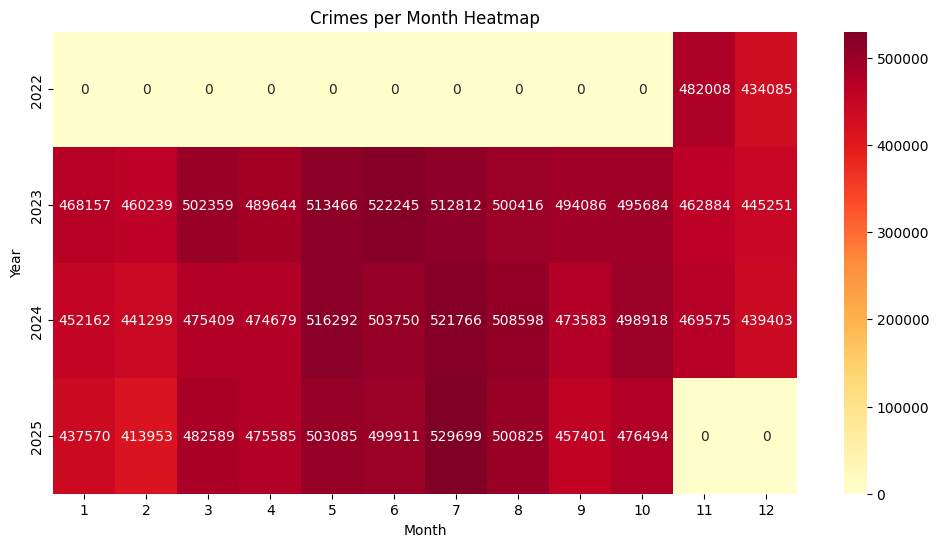

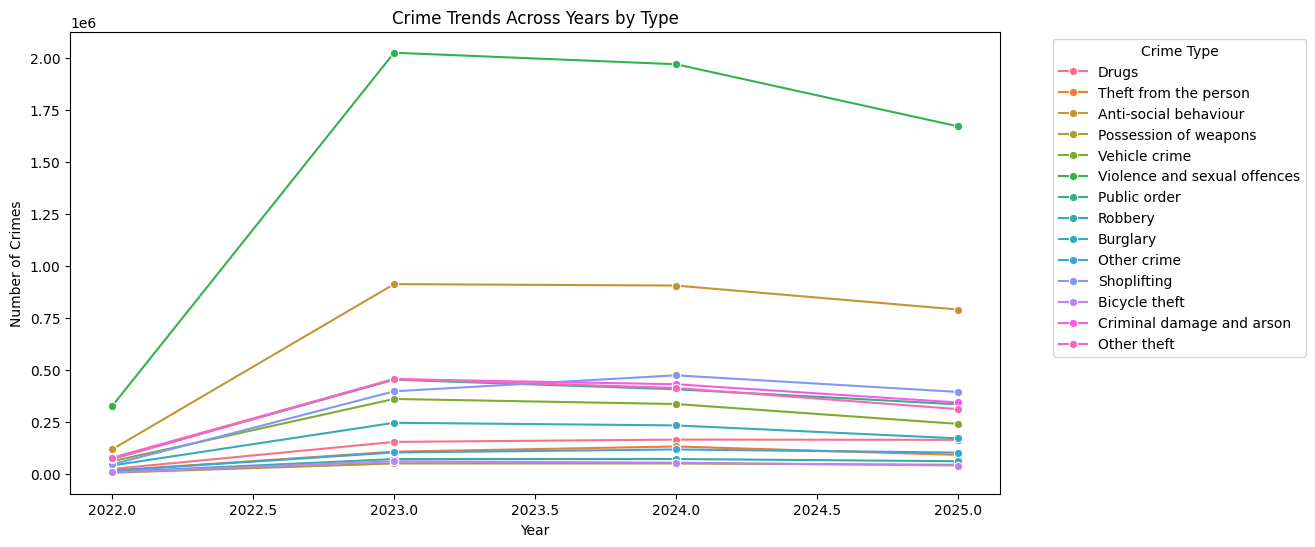

In [9]:
# 1. Aggregate total crimes per month and year
monthly_counts_df = (
    df_clean.groupBy("year", "month_num")
      .agg(sql_f.count("*").alias("crime_count"))
      .orderBy("year", "month_num")
)

monthly_counts_pd = monthly_counts_df.toPandas()

# Pivot to make heatmap friendly (rows=year, columns=month)
heatmap_data = monthly_counts_pd.pivot(index="year", columns="month_num", values="crime_count").fillna(0)

# 2. Plot heatmap of crimes per month/year
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlOrRd")
plt.title("Crimes per Month Heatmap")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

# 3. Trend across years per crime type
trend_df = (
    df_clean.groupBy("year", "crime_type")
      .agg(sql_f.count("*").alias("crime_count"))
      .orderBy("year")
)

trend_pd = trend_df.toPandas()

# Lineplot for trend
plt.figure(figsize=(12,6))
sns.lineplot(data=trend_pd, x="year", y="crime_count", hue="crime_type", marker="o")
plt.title("Crime Trends Across Years by Type")
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.legend(title="Crime Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

/tmp/ipykernel_428771/1997950758.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crime_rates.index, y=crime_rates.values, order=crime_rates.index, palette="tab10")


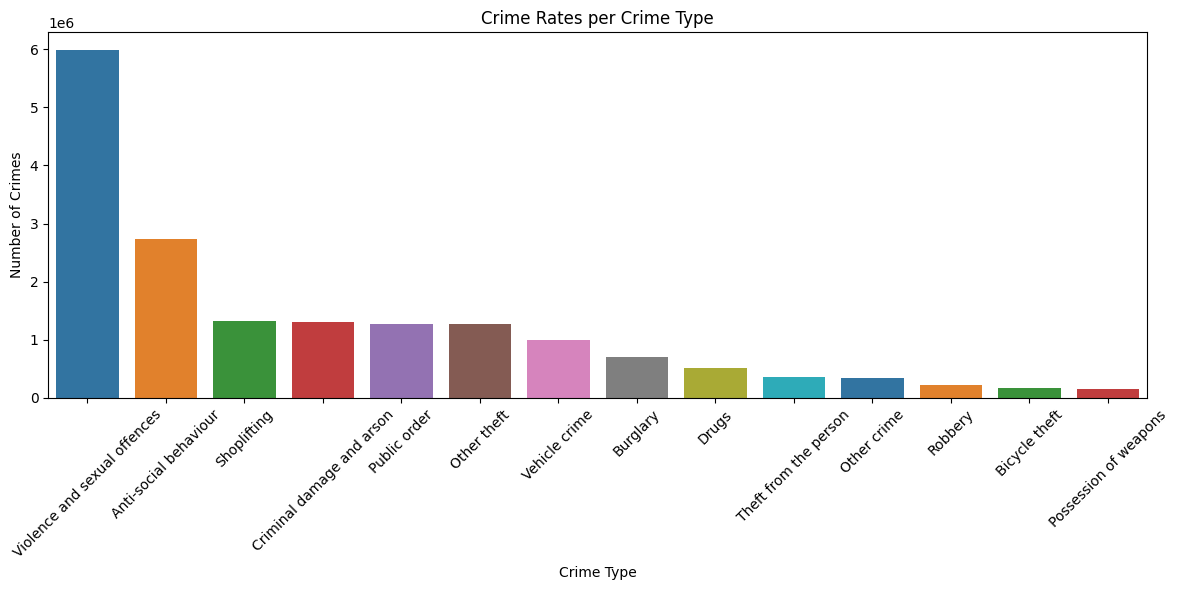

In [20]:
# Barplot of crime rate per crime type, ordered
plt.figure(figsize=(12,6))
crime_rates = trend_pd.groupby("crime_type")["crime_count"].sum().sort_values(ascending=False)
sns.barplot(x=crime_rates.index, y=crime_rates.values, order=crime_rates.index, palette="tab10")
plt.title("Crime Rates per Crime Type")
plt.xlabel("Crime Type")
plt.ylabel("Number of Crimes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In the heatmap, we can clearly see which data range we posses. 2023 and 2024 are the only years with information for each month. 2022 starts at November, and 2025 ends at October.

Taking a look at our crime-type distribution, we can see the two most common crime types are **Violence and sexual offences** and **Anti-social behaviour**, the first one having considerably more than the rest.

While crime rate seems to be going down in general, some types saw a increase:
 - 'Shoplifting' went up between 2023 and 2024.
 - 'Other theft' kept going up, although we don't know which exactly classifies for this tpye.

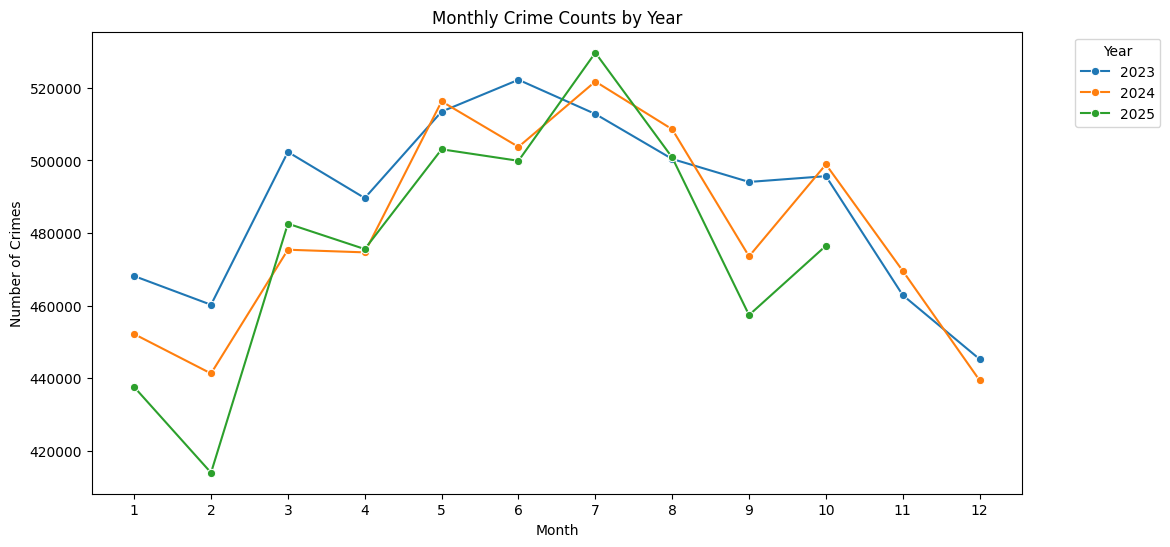

In [26]:
monthly_counts_pd = monthly_counts_df.toPandas()

monthly_counts_pd = monthly_counts_pd.sort_values(["year", "month_num"])
monthly_counts_pd = monthly_counts_pd[monthly_counts_pd.year != 2022]

# Line plot: one line per year, months on x-axis
plt.figure(figsize=(12,6))
sns.lineplot(
    data=monthly_counts_pd,
    x="month_num",
    y="crime_count",
    hue="year",
    marker="o",
    palette="tab10"
)
plt.title("Monthly Crime Counts by Year")
plt.xlabel("Month")
plt.ylabel("Number of Crimes")
plt.xticks(range(1,13))  # Ensure all months 1-12 are shown
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Using a line-plot allows us to more easily identify the trend in crim-rates by month more easily in comparison to the previous heatmap.
We can see a clear ciclic pattern, with peak crime rates being in summer, and lowest crime rates in winter. This repeats for all years (2022 excluded due to low data).

This checks out with our intuition, summer being the period of the year with more activity and tourism.

We will use this information later for feature engeniering.

   year  crime_count
0  2023      5177185
1  2024      5057092
2  2025      4966115


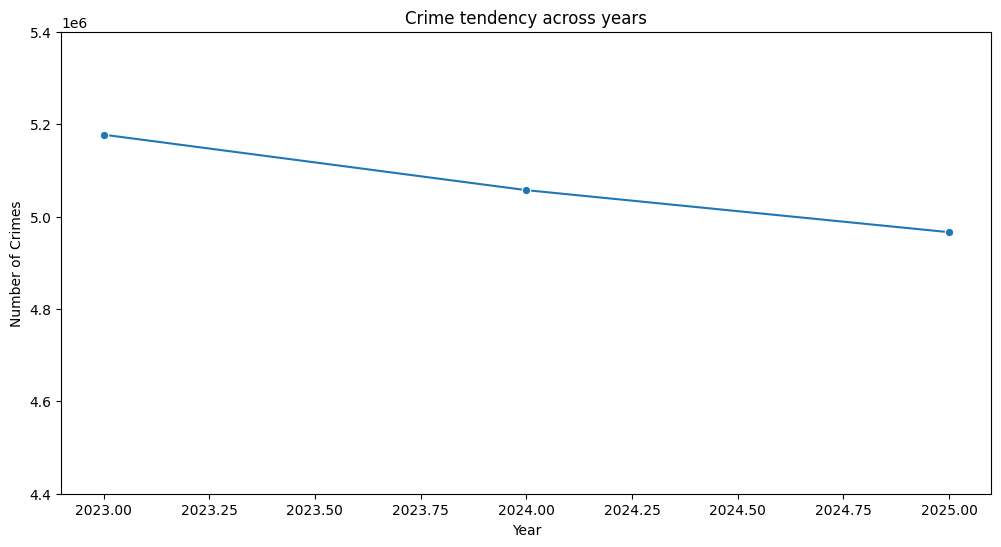

In [28]:
crimes_per_year = df.filter("year > 2022").filter("month_num < 11")\
            .groupBy("year")\
            .agg(sql_f.count("*").alias("crime_count"))\
            .orderBy("year")\
            .toPandas()

print(crimes_per_year)

plt.figure(figsize=(12,6))
sns.lineplot(
    data=crimes_per_year,
    x="year",
    y="crime_count",
    marker="o",
)
plt.title("Crime tendency across years")
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.ylim(4400000, 5400000)
#plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Lastly, checking the total crime-rate trend between years, we can see crime rates are going down. The year 2022 and the months November and December where not counted to have a more realistic metric due to missing data.

### Spatial Analysis

Now we will get into the spatial analysis of our dataset, our main focus for the rest of the project. 

Our dataset contains both LSOA and latitude and longitude information of where the crime was reported:
 - LSOA (Lower layer Super Output Area) are small UK area subdivission, areas used to help in analysis.
 - Latitude and longitude allows to pinpoint the exact position in the map.

With this information avalible, is of great interest to analyse the distribution of crime rates in a map. This allows police stations to better distribute its work force, allowing for a more optimal control of the area and prevent or react faster to crimes. 

Let's start imoporting some libraries to help plot maps.

In [5]:
!pip install geopandas
!pip install shapely
import geopandas as gpd
import shapely
from shapely.geometry import Point

Now, we will proceed to visualize the crime rates in London, divided by LSOA regions:

- We will start counting the number of reports per LSOA.
- Geopandas allows to load geographic information, in our case related to LSOA regions.

In [6]:
crimes_by_lsoa = df_clean.groupBy("lsoa_name") \
    .count() \
    .withColumnRenamed("count", "crime_count") \
    .orderBy("crime_count", ascending=False)

crimes_by_lsoa.write.mode("overwrite").parquet("output/crimes_by_lsoa.parquet")

print(crimes_by_lsoa.show(10))

+-------------------+-----------+
|          lsoa_name|crime_count|
+-------------------+-----------+
|   Westminster 013G|      38126|
|   Westminster 013B|      33945|
|   Westminster 018A|      33206|
|         Leeds 111B|      23497|
|City of London 001F|      21975|
|   Westminster 018C|      19279|
|    Birmingham 138A|      17433|
|     Liverpool 060C|      16579|
|    Hillingdon 031A|      16273|
|       Cardiff 032H|      15447|
+-------------------+-----------+
only showing top 10 rows
None


Here we see the top 10 crime rate LSOAs. We can see Westminster is a high crime concentration area!

Now, we will load the London geographic information and prepare the geometry to later plot

In [7]:
boroughs_gdf = gpd.read_file("london_boroughs.geojson").to_crs(epsg=4326)
lsoa_gdf = gpd.read_file("lsoa.geojson").to_crs(epsg=4326)

lsoa_centroids = lsoa_gdf.copy()
lsoa_centroids["geometry"] = lsoa_centroids.geometry.centroid

lsoa_london = gpd.sjoin(
    lsoa_centroids,
    boroughs_gdf,
    how="inner",
    predicate="within"
)

lsoa_london = lsoa_london[["LSOA11CD", "LSOA11NM"]]


/tmp/ipykernel_448112/3819734082.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lsoa_centroids["geometry"] = lsoa_centroids.geometry.centroid


We only keep LSOA names present in the London map

In [8]:
london_lsoa_names = lsoa_london["LSOA11NM"].tolist()

lsoa_gdf_london = lsoa_gdf[lsoa_gdf["LSOA11NM"].isin(london_lsoa_names)]

crimes_agg = spark.read.parquet("output/crimes_by_lsoa.parquet")
crimes_agg_london = crimes_agg.filter(sql_f.col("lsoa_name").isin(london_lsoa_names)).toPandas()


merged_gdf = lsoa_gdf_london.merge(
    crimes_agg_london,
    left_on="LSOA11NM",
    right_on="lsoa_name",
    how="left"
)

merged_gdf["crime_count"] = merged_gdf["crime_count"].fillna(0)


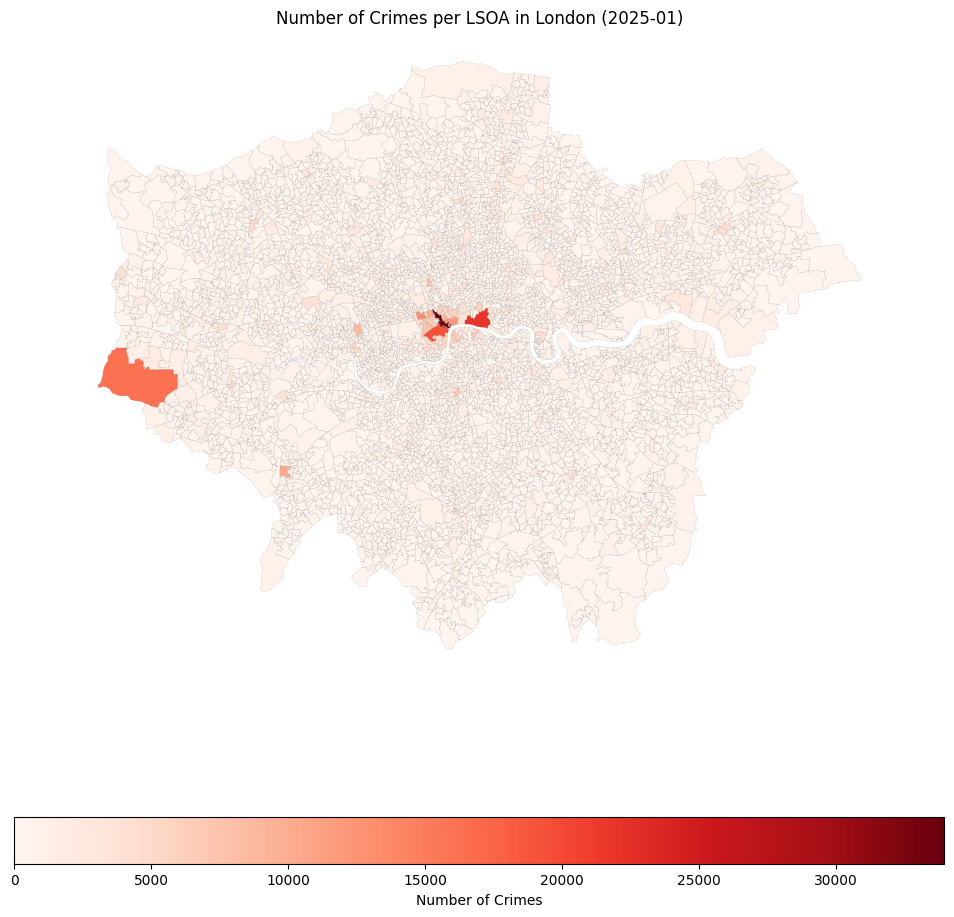

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
merged_gdf.plot(
    column="crime_count",
    cmap="Reds",
    linewidth=0.1,
    ax=ax,
    edgecolor="0.5",
    legend=True,
    legend_kwds={"label": "Number of Crimes", "orientation": "horizontal"},
    missing_kwds={"color": "lightgrey"}
)
ax.set_title("Number of Crimes per LSOA in London (2025-01)")
ax.axis("off")
plt.show()


This map shows a clear pattern in London: Crime is more concentrated at the center. 
We also see some small hotspots spread around London, with a big hotspot showing at the west of London. 

In [10]:
from pyspark.sql.window import Window

crimes_by_lsoa_type = df_clean.groupBy(
    "lsoa_name",
    "crime_type"
).count()

In [11]:
window = Window.partitionBy("lsoa_name").orderBy(sql_f.desc("count"))

dominant_crime_by_lsoa = crimes_by_lsoa_type \
    .withColumn("rank", sql_f.row_number().over(window)) \
    .filter(sql_f.col("rank") == 1) \
    .select(
        "lsoa_name",
        sql_f.col("crime_type").alias("dominant_crime"),
        sql_f.col("count").alias("crime_count")
    )

In [12]:
dominant_pd = dominant_crime_by_lsoa.toPandas()

In [13]:
london_lsoa_names = lsoa_london["LSOA11NM"].unique()
lsoa_gdf_london = lsoa_gdf[lsoa_gdf["LSOA11NM"].isin(london_lsoa_names)]

In [14]:
merged_gdf = lsoa_gdf_london.merge(
    dominant_pd,
    left_on="LSOA11NM",
    right_on="lsoa_name",
    how="left"
)

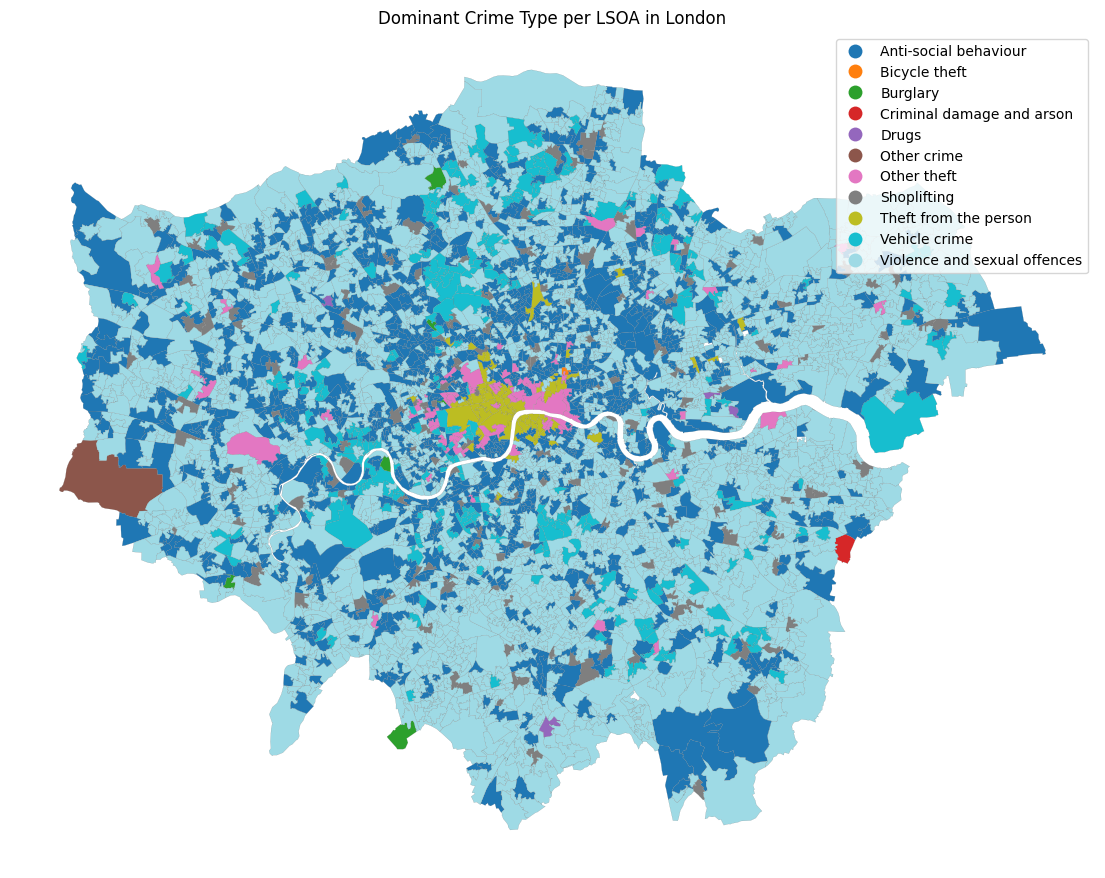

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(14, 14))

merged_gdf.plot(
    column="dominant_crime",
    categorical=True,
    legend=True,
    cmap=plt.get_cmap("tab20"),
    linewidth=0.1,
    ax=ax,
    edgecolor="0.4"
)

ax.set_title("Dominant Crime Type per LSOA in London")
ax.axis("off")
plt.show()


Plotting the most common crime type by area also shows us more information. **Violence and sexual offences** and **Anti-social behaviour** are still the most common ones, but **Theft from person** and **Other theft** are the most common at the center area.

Others like **Shoplifting** are also present across all map, while others like **Drugs** or **Criminal damage and arson** are only present in some small areas.

Now, using the latitude and longitude values of our dataset, we will do a heatmap of the entire UK.
We will subdivide the area into a grid-size of 0.01, which corresponds more or less to celss of 1 km squared. Once crime rates are agregated per km-squared, we will plot a KDE (Kernel Density Estimate) of the UK.

Same as before, we will use geopandas to load a shape file of UK to plot our KDE on top of.

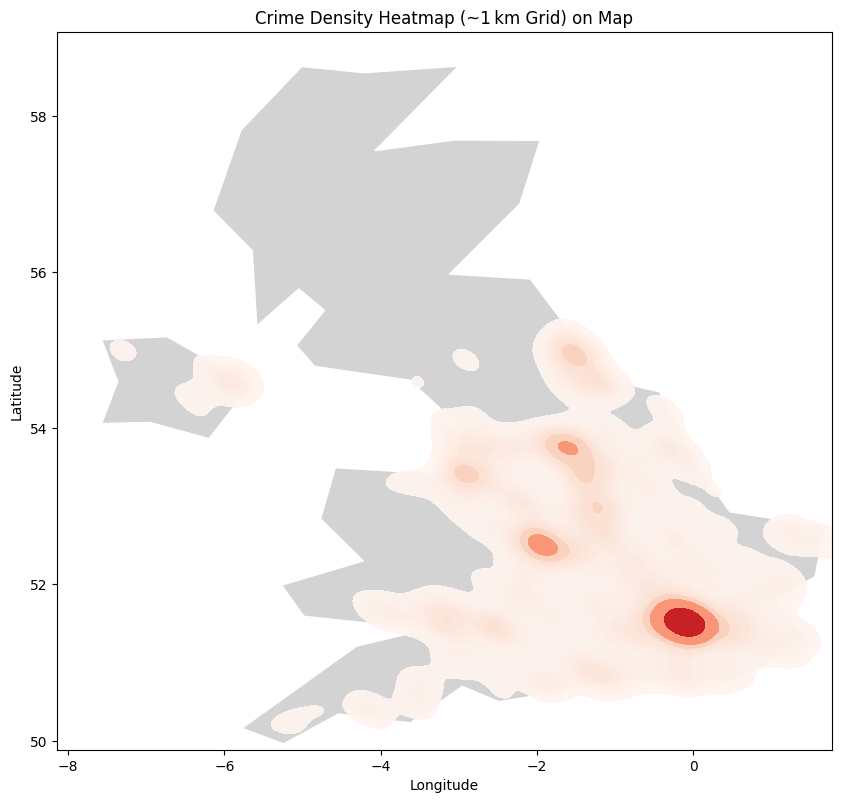

In [ ]:
# Create spatial bins
grid_size = 0.01  # ~1 km grid

df_binned = df.withColumn("lat_bin", (F.col("latitude")/grid_size).cast("int")) \
              .withColumn("lon_bin", (F.col("longitude")/grid_size).cast("int"))

# Count crimes per grid cell
grid_counts_df = (
    df_binned.groupBy("lat_bin", "lon_bin")
             .agg(F.count("*").alias("crime_count"))
             .orderBy(F.desc("crime_count"))
)

# Collect to pandas
grid_counts_pd = grid_counts_df.toPandas()

# Recover approximate central coordinates for plotting
grid_counts_pd["lat_center"] = (grid_counts_pd["lat_bin"] + 0.5) * grid_size
grid_counts_pd["lon_center"] = (grid_counts_pd["lon_bin"] + 0.5) * grid_size

#Plot heatmap overlayed on basemap
geometry = [Point(xy) for xy in zip(grid_counts_pd["lon_center"],
                                   grid_counts_pd["lat_center"])]
gdf_grid = gpd.GeoDataFrame(grid_counts_pd,
                            geometry=geometry,
                            crs="EPSG:4326")


world = gpd.read_file('map/ne_110m_admin_0_countries.dbf')
basemap = world[world["NAME"] == "United Kingdom"]

fig, ax = plt.subplots(figsize=(10, 10))

basemap.to_crs(epsg=4326).plot(ax=ax,
                              color="lightgray",
                              edgecolor="white")


sns.kdeplot(
    x=gdf_grid.geometry.x,
    y=gdf_grid.geometry.y,
    weights=gdf_grid["crime_count"], 
    fill=True,
    cmap="Reds",
    thresh=0.05,
    bw_adjust=0.5,
    alpha=0.95,
    ax=ax,
    clip=(
        (gdf_grid["lon_center"].min() - 0.01,
         gdf_grid["lon_center"].max() + 0.01),
        (gdf_grid["lat_center"].min() - 0.01,
         gdf_grid["lat_center"].max() + 0.01)
    )
)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Crime Density Heatmap (~1 km Grid) on Map")
ax.set_aspect("equal")
plt.show()


We can identify multiple spots in the map, with 3 main ones showing. These three are London, Birmingham and Leeds, three of the biggest cities of UK.

London is clearly visible in the heatmap, being the biggest crime spot in UK.

## Hotspot Prediction

The analysis already shows a lot of valuable information regarding crime rates by area in UK, but we are limited to the dates of information we dispose of.
We are now going to try to train a model to predict hotspots for a specific year and month. This could allow police stations to predict future crime hotspots and anticipate by distributing work force acordingly.

In [6]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.window import Window
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

We will start by creating our data preprocessor. Our preprocessing will consist of the following:
 - For a grid, count crime-rate per bin, year and month
 - Mark the 90 percentile as *hotspot*
 - Create new month features
 - Add time index (used to split data)
 - Assemble features into a vector

In this preprocesing, we create two new features: *month_sin* and *month_cos*. This allows the model to treat the month as a ciclic variable as we have seen earlier in the plots, instead of linearly.
We also create variables to save the latitude and longitude bounding box of both London and UK. This will help us later to plot and filter data.

Our final training feature vector is composed of: *lat_bin*, *lon_bin*, *month_sin*, *month_cos* and *year*. This gives the model both spatial and temporal information.

In [7]:
# Coordinates used to define the area of interest
LONDON_LAT_MIN = 51.28
LONDON_LAT_MAX = 51.70
LONDON_LON_MIN = -0.55
LONDON_LON_MAX = 0.35

UK_LAT_MIN = 49.8   
UK_LAT_MAX = 55.9   
UK_LON_MIN = -6.0   
UK_LON_MAX =  2.0


feature_cols = [
    "lat_bin",
    "lon_bin",
    "month_sin",
    "month_cos",
    "year"
]

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

def preprocess_df(df, grid_size, assembler):
    df_grid = (
        df
        .withColumn("lat_bin", (F.col("latitude") / grid_size).cast("int"))
        .withColumn("lon_bin", (F.col("longitude") / grid_size).cast("int"))
    )

    monthly_grid_df = (
        df_grid
        .groupBy("lat_bin", "lon_bin", "year", "month_num")
        .agg(F.count("*").alias("crime_count"))
    )

    percentile = 0.90
    thresholds = (
        monthly_grid_df
        .groupBy("year", "month_num")
        .agg(F.expr(f"percentile_approx(crime_count, {percentile})").alias("hotspot_threshold"))
    )

    labeled_df = (
        monthly_grid_df
        .join(thresholds, on=["year", "month_num"])
        .withColumn(
            "hotspot",
            (F.col("crime_count") >= F.col("hotspot_threshold")).cast("int")
        )
    )

    features_df = (
        labeled_df
        .withColumn("month_sin", F.sin(2 * 3.14159 * F.col("month_num") / 12))
        .withColumn("month_cos", F.cos(2 * 3.14159 * F.col("month_num") / 12))
        .withColumn("time_index",F.col("year") * 12 + F.col("month_num"))
    )

    final_df = assembler.transform(features_df).select(
        "features", "hotspot", "year", "month_num", "lat_bin", "lon_bin", "time_index"
    )

    return final_df

Now, lets train two different models of two different resolutions:
 - Smaller spatial resolution (~1 km) for full UK
 - Higher spatial resolution (~100 m) for London only 

### Training a model on the full UK

We start preprocessing our data for the hole UK. Here we use the newly created *time_index* to split the data into train and test, since we want to keep data continuous. We will keep the las 5 months for test data.

In [10]:
grid_size = 0.01  # ~1km

final_df = preprocess_df(df_clean, grid_size, assembler)

max_time = final_df.agg(F.max("time_index")).collect()[0][0]

test_horizon = 5
cutoff_time = max_time - test_horizon

train_df = final_df.filter(F.col("time_index") <= cutoff_time).cache()
test_df  = final_df.filter(F.col("time_index") > cutoff_time)

print(train_df.count(), test_df.count())

1160517 192029


We will try a few models and compare which one offers the best results. The best model will be the one used for Londo prediction and scalability testing.

We will try the following models:
- Linear Regression
- Random Forest
- Gradient Boosting

For the final evaluation metric, we will use AUC-ROC and AUC-PR, for being robust, threshold independent metrics. We visualize both to get a better understanding of the model's performance, since AUC-ROC is more sensitive to class imbalance.

In [8]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# create the trainer and set its parameters
trainer = RandomForestClassifier(
    labelCol="hotspot", 
    featuresCol="features", 
    maxDepth=8,
    numTrees=180,
    seed=42
)

# train the model
model = trainer.fit(train_df)

# compute accuracy on the test set
predictions = model.transform(test_df)

evaluator = BinaryClassificationEvaluator(
    labelCol="hotspot",
    metricName="areaUnderROC"
)
auc = evaluator.evaluate(predictions)

pr_evaluator = BinaryClassificationEvaluator(
    labelCol="hotspot",
    metricName="areaUnderPR"
)
pr_score = pr_evaluator.evaluate(predictions)

print(f"AUC: {auc:.3f}")
print(f"PR Score: {pr_score:.3f}")

26/01/10 13:41:04 WARN MemoryStore: Not enough space to cache rdd_119_98 in memory! (computed 3.6 MiB so far)
26/01/10 13:41:04 WARN MemoryStore: Not enough space to cache rdd_119_95 in memory! (computed 29.1 MiB so far)
26/01/10 13:41:04 WARN BlockManager: Persisting block rdd_119_95 to disk instead.
26/01/10 13:41:04 WARN BlockManager: Persisting block rdd_119_98 to disk instead.
26/01/10 13:41:05 WARN MemoryStore: Not enough space to cache rdd_119_102 in memory! (computed 1029.9 KiB so far)
26/01/10 13:41:05 WARN BlockManager: Persisting block rdd_119_102 to disk instead.
26/01/10 13:41:05 WARN MemoryStore: Not enough space to cache rdd_119_95 in memory! (computed 18.7 MiB so far)
26/01/10 13:41:05 WARN MemoryStore: Not enough space to cache rdd_119_104 in memory! (computed 8.2 MiB so far)
26/01/10 13:41:05 WARN BlockManager: Persisting block rdd_119_104 to disk instead.
26/01/10 13:41:05 WARN MemoryStore: Not enough space to cache rdd_119_98 in memory! (computed 29.1 MiB so far)
26

AUC: 0.703
PR Score: 0.343


In [12]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Layers: 5 input features, two hidden layers (16 and 8 neurons), and 2 output classes
layers = [5, 128, 64, 2]

mlp = MultilayerPerceptronClassifier(
    labelCol="hotspot",
    featuresCol="features",
    layers=layers,
    maxIter=400,
    blockSize=128,
    seed=42
)

model = mlp.fit(train_df)

predictions = model.transform(test_df)

evaluator = BinaryClassificationEvaluator(
    labelCol="hotspot",
    metricName="areaUnderROC"
)
auc = evaluator.evaluate(predictions)

pr_evaluator = BinaryClassificationEvaluator(
    labelCol="hotspot",
    metricName="areaUnderPR"
)
pr_score = pr_evaluator.evaluate(predictions)

print(f"AUC: {auc:.3f}")
print(f"PR Score: {pr_score:.3f}")

AUC: 0.556
PR Score: 0.114


In [10]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

gbt = GBTClassifier(
    labelCol="hotspot",
    featuresCol="features",
    maxIter=100,
    maxDepth=6,
    seed=42
)

model = gbt.fit(train_df)

predictions = model.transform(test_df)

evaluator = BinaryClassificationEvaluator(
    labelCol="hotspot",
    metricName="areaUnderROC"
)
auc = evaluator.evaluate(predictions)

pr_evaluator = BinaryClassificationEvaluator(
    labelCol="hotspot",
    metricName="areaUnderPR"
)
pr_score = pr_evaluator.evaluate(predictions)

print(f"AUC: {auc:.3f}")
print(f"PR Score: {pr_score:.3f}")

26/01/10 13:54:28 WARN DAGScheduler: Broadcasting large task binary with size 1002.1 KiB
26/01/10 13:54:30 WARN DAGScheduler: Broadcasting large task binary with size 1002.6 KiB
26/01/10 13:54:31 WARN DAGScheduler: Broadcasting large task binary with size 1003.2 KiB
26/01/10 13:54:33 WARN DAGScheduler: Broadcasting large task binary with size 1004.4 KiB
26/01/10 13:54:34 WARN DAGScheduler: Broadcasting large task binary with size 1006.8 KiB
26/01/10 13:54:36 WARN DAGScheduler: Broadcasting large task binary with size 1011.4 KiB
26/01/10 13:54:38 WARN DAGScheduler: Broadcasting large task binary with size 1014.3 KiB
26/01/10 13:54:40 WARN DAGScheduler: Broadcasting large task binary with size 1014.8 KiB
26/01/10 13:54:41 WARN DAGScheduler: Broadcasting large task binary with size 1015.4 KiB
26/01/10 13:54:43 WARN DAGScheduler: Broadcasting large task binary with size 1016.6 KiB
26/01/10 13:54:44 WARN DAGScheduler: Broadcasting large task binary with size 1019.0 KiB
26/01/10 13:54:46 WAR

AUC: 0.812
PR Score: 0.433


We obtaine the following results:
 - **Random Forest**: AUC: 0.703 | PR Score: 0.343
 - **MLP**: AUC: 0.556 | PR Score: 0.114
 - **GBT**: AUC: 0.812 | PR Score: 0.433

The GBT model is the best model for this task. While the metrics show the model its not perfect at this task, it can capture the general trend of the data. We will later plot the predictions.

We can also calculate the precission for the top k predicted hotspots.

In [12]:
from pyspark.ml.functions import vector_to_array

pred_scored = predictions.withColumn(
    "p_hotspot",
    vector_to_array(col("probability"))[1]
)

pred_sorted = pred_scored.orderBy(col("p_hotspot").desc())

def precision_at_k(df, k):
    top_k = df.limit(k)
    return top_k.agg({"hotspot": "avg"}).collect()[0][0]

for k in [50, 1200, 6000]:
    print(f"P@{k} =", precision_at_k(pred_sorted, k))

26/01/10 14:42:05 WARN DAGScheduler: Broadcasting large task binary with size 1339.9 KiB
26/01/10 14:42:07 WARN DAGScheduler: Broadcasting large task binary with size 1315.8 KiB


P@50 = 0.98


26/01/10 14:42:11 WARN DAGScheduler: Broadcasting large task binary with size 1339.9 KiB
26/01/10 14:42:13 WARN DAGScheduler: Broadcasting large task binary with size 1315.8 KiB


P@1200 = 0.9208333333333333


26/01/10 14:42:18 WARN DAGScheduler: Broadcasting large task binary with size 1339.9 KiB


P@6000 = 0.6673333333333333


26/01/10 14:42:19 WARN DAGScheduler: Broadcasting large task binary with size 1315.8 KiB


- P@50 = 0.98          
- P@1200 = 0.9208333333333333
- P@6000 = 0.6673333333333333

The models top-k precision goes down as k increases. Knowing the model learns an aproximation of the data, top predicted values are more likely to be correct.

Now we will take a look at the feature importance of the model, to understand which features are most important for the prediction.

In [23]:
importances = model.featureImportances.toArray()
feature_importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df


,Feature,Importance
0,lat_bin,0.502690
1,lon_bin,0.494102
4,year,0.002072
3,month_cos,0.000706
2,month_sin,0.000430


We can see that the model effectively only uses latitude and longitude to make predictions, without being able to capture more information related to date. This tells us that hotspots do not tend to vary much over time. Having information of more years could help the model to capture more variation in the data.

Now, we will predict a hotspot map with the trained model. The following function will create for an area, grid-size and date, a dataframe composed of rows for each point. Predicting this dataframe will yield predictions for the full map area.

Once all points have been predicted, we will plot the predicted probabilities in a map, showing the hotspot patter learnt by the model.

In [8]:
from pyspark.sql.types import DoubleType

def predict_hotspots_for_area(
    spark,
    model,
    vector_assembler,
    grid_size,
    lat_min,
    lat_max,
    lon_min,
    lon_max,
    year,
    month
):

    # Create latitude / longitude bin ranges
    lat_bins = (
        spark.range(
            int(lat_min / grid_size),
            int(lat_max / grid_size) + 1
        )
        .withColumnRenamed("id", "lat_bin")
    )

    lon_bins = (
        spark.range(
            int(lon_min / grid_size),
            int(lon_max / grid_size) + 1
        )
        .withColumnRenamed("id", "lon_bin")
    )

    # Create full grid (cartesian product)
    grid_df = lat_bins.crossJoin(lon_bins)

    # Add time features
    grid_df = (
        grid_df
        .withColumn("year", F.lit(year))
        .withColumn("month_num", F.lit(month))
        .withColumn(
            "month_sin",
            F.sin(F.lit(2 * 3.14159265 * month / 12))
        )
        .withColumn(
            "month_cos",
            F.cos(F.lit(2 * 3.14159265 * month / 12))
        )
    )

    # Assemble features
    grid_features = vector_assembler.transform(grid_df)

    # Predict
    predictions = model.transform(grid_features)

    # Extract hotspot probability (class = 1)
    extract_prob = F.udf(lambda v: float(v[1]), DoubleType())

    predictions = predictions.withColumn(
        "p_hotspot",
        extract_prob(F.col("probability"))
    )

    # Convert bins to coordinates (center of cell)
    predictions = (
        predictions
        .withColumn("latitude", (F.col("lat_bin") + 0.5) * grid_size)
        .withColumn("longitude", (F.col("lon_bin") + 0.5) * grid_size)
    )

    return predictions.select(
        "latitude",
        "longitude",
        "lat_bin",
        "lon_bin",
        "p_hotspot"
    )

We will start ploting the real hotspots from our train data

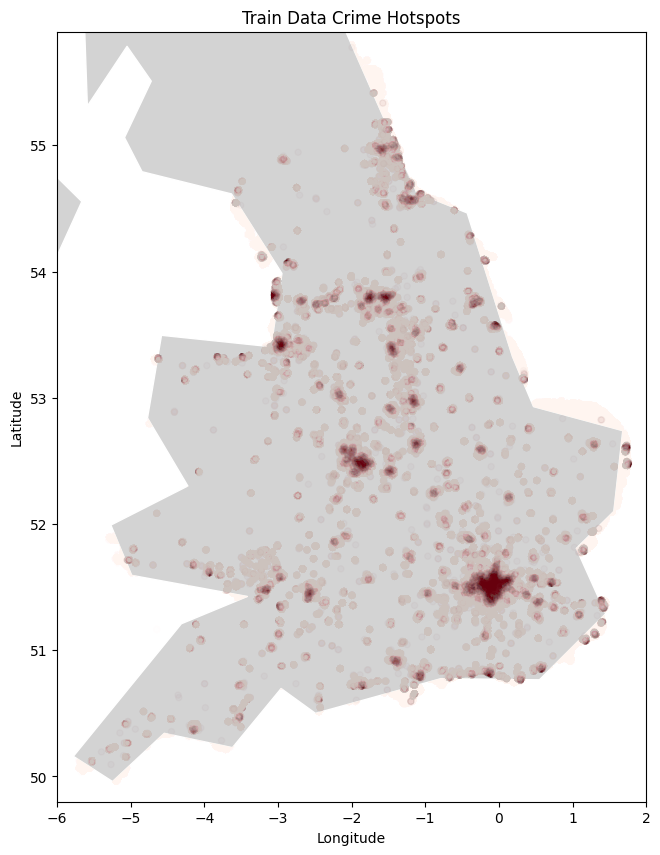

In [15]:
world = gpd.read_file('map/ne_110m_admin_0_countries.dbf')
basemap = world[world["NAME"] == "United Kingdom"]


real_spot = (
    train_df
    .withColumn("latitude", (F.col("lat_bin") + 0.5) * grid_size)
    .withColumn("longitude", (F.col("lon_bin") + 0.5) * grid_size)
).toPandas()


fig, ax = plt.subplots(figsize=(10, 10))

basemap.to_crs(epsg=4326).plot(ax=ax,
                              color="lightgray",
                              edgecolor="white")

sc = plt.scatter(
    real_spot["longitude"],
    real_spot["latitude"],
    c=real_spot["hotspot"],
    cmap="Reds",
    s=20,
    alpha=0.02
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Train Data Crime Hotspots")
plt.xlim(UK_LON_MIN, UK_LON_MAX)
plt.ylim(UK_LAT_MIN, UK_LAT_MAX)

plt.show()

And now, we will predict the map area and plot the probability of crime in each area.

26/01/10 14:52:37 WARN DAGScheduler: Broadcasting large task binary with size 1274.7 KiB


<Figure size 1000x1000 with 0 Axes>

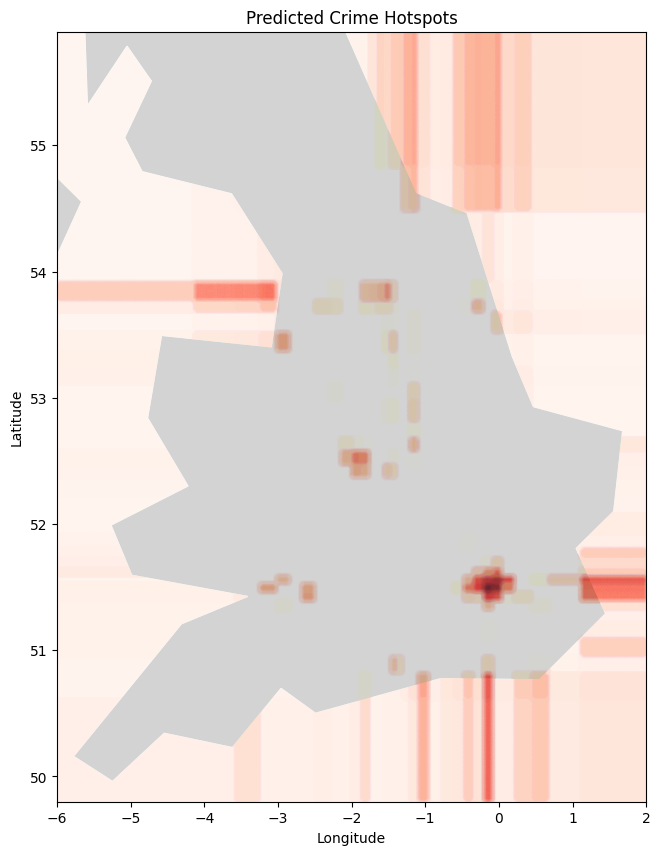

In [18]:
london_preds = predict_hotspots_for_area(
    spark=spark,
    model=model,
    vector_assembler=assembler,
    grid_size=grid_size,
    lat_min=UK_LAT_MIN,
    lat_max=UK_LAT_MAX,
    lon_min=UK_LON_MIN,
    lon_max=UK_LON_MAX,
    year=2025,
    month=7
)

pred_pd = london_preds.toPandas().sort_values("p_hotspot", ascending=False)

plt.figure(figsize=(10, 10))


world = gpd.read_file('map/ne_110m_admin_0_countries.dbf')
basemap = world[world["NAME"] == "United Kingdom"]

fig, ax = plt.subplots(figsize=(10, 10))

basemap.to_crs(epsg=4326).plot(ax=ax,
                              color="lightgray",
                              edgecolor="white")

sc = plt.scatter(
    pred_pd["longitude"],
    pred_pd["latitude"],
    c=pred_pd["p_hotspot"],
    cmap="Reds",
    s=20,
    alpha=0.02
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Predicted Crime Hotspots")
plt.xlim(UK_LON_MIN, UK_LON_MAX)
plt.ylim(UK_LAT_MIN, UK_LAT_MAX)

plt.show()

We can see that, although precision of the model is not high, the model is able to learn an aproximation of the hotspots. Areas outside the map have weird predictions due to no data related to those coordinates.

### Hotspot Detection London

Now, we will do the same process as before, but specific to london with a higher spatial resolution.

In [9]:
grid_size = 0.001  # ~100m

london_df = df_clean.filter(
         (F.col("latitude").between(LONDON_LAT_MIN, LONDON_LAT_MAX)) &
         (F.col("longitude").between(LONDON_LON_MIN, LONDON_LON_MAX))
    )

final_df = preprocess_df(
    london_df,
    grid_size,
    assembler
)

max_time = final_df.agg(F.max("time_index")).collect()[0][0]

test_horizon = 5
cutoff_time = max_time - test_horizon

train_df = final_df.filter(F.col("time_index") <= cutoff_time).cache()
test_df  = final_df.filter(F.col("time_index") > cutoff_time)

print(train_df.count(), test_df.count())

1032757 171280


We will save the train_df for later use in the scalability testing

In [25]:
train_df.write.mode("overwrite").parquet("train_df.parquet")


We will only train GBTClassifier since it has shown to yield the best results.

In [11]:
gbt = GBTClassifier(
    labelCol="hotspot",
    featuresCol="features",
    maxIter=100,
    maxDepth=6,
    seed=42
)

model = gbt.fit(train_df)
model.write().overwrite().save("models/gbt_model_london")

predictions = model.transform(test_df)

evaluator = BinaryClassificationEvaluator(
    labelCol="hotspot",
    metricName="areaUnderROC"
)
auc = evaluator.evaluate(predictions)

pr_evaluator = BinaryClassificationEvaluator(
    labelCol="hotspot",
    metricName="areaUnderPR"
)
pr_score = pr_evaluator.evaluate(predictions)

print(f"AUC: {auc:.3f}")
print(f"PR Score: {pr_score:.3f}")

26/01/11 12:06:37 WARN DAGScheduler: Broadcasting large task binary with size 1000.7 KiB
26/01/11 12:06:39 WARN DAGScheduler: Broadcasting large task binary with size 1003.9 KiB
26/01/11 12:06:41 WARN DAGScheduler: Broadcasting large task binary with size 1004.4 KiB
26/01/11 12:06:43 WARN DAGScheduler: Broadcasting large task binary with size 1004.9 KiB
26/01/11 12:06:44 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB
26/01/11 12:06:46 WARN DAGScheduler: Broadcasting large task binary with size 1008.5 KiB
26/01/11 12:06:48 WARN DAGScheduler: Broadcasting large task binary with size 1013.2 KiB
26/01/11 12:06:49 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
26/01/11 12:06:51 WARN DAGScheduler: Broadcasting large task binary with size 1016.9 KiB
26/01/11 12:06:53 WARN DAGScheduler: Broadcasting large task binary with size 1017.5 KiB
26/01/11 12:06:55 WARN DAGScheduler: Broadcasting large task binary with size 1018.7 KiB
26/01/11 12:06:56 WAR

AUC: 0.729
PR Score: 0.280


In [25]:
importances = model.featureImportances.toArray()
feature_importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df

,Feature,Importance
0,lat_bin,0.527549
1,lon_bin,0.446484
2,month_sin,0.011006
4,year,0.009213
3,month_cos,0.005748


We obtain the following results:
- AUC: 0.729
- PR Score: 0.280

The prediction capabilities of the model show to be worse than training on the hole UK. More spatial resolution might have made the data less smooth, making it more difficult to predict.\

The same way, latitude and longitude are the predominant features, showing little information gain from time features.


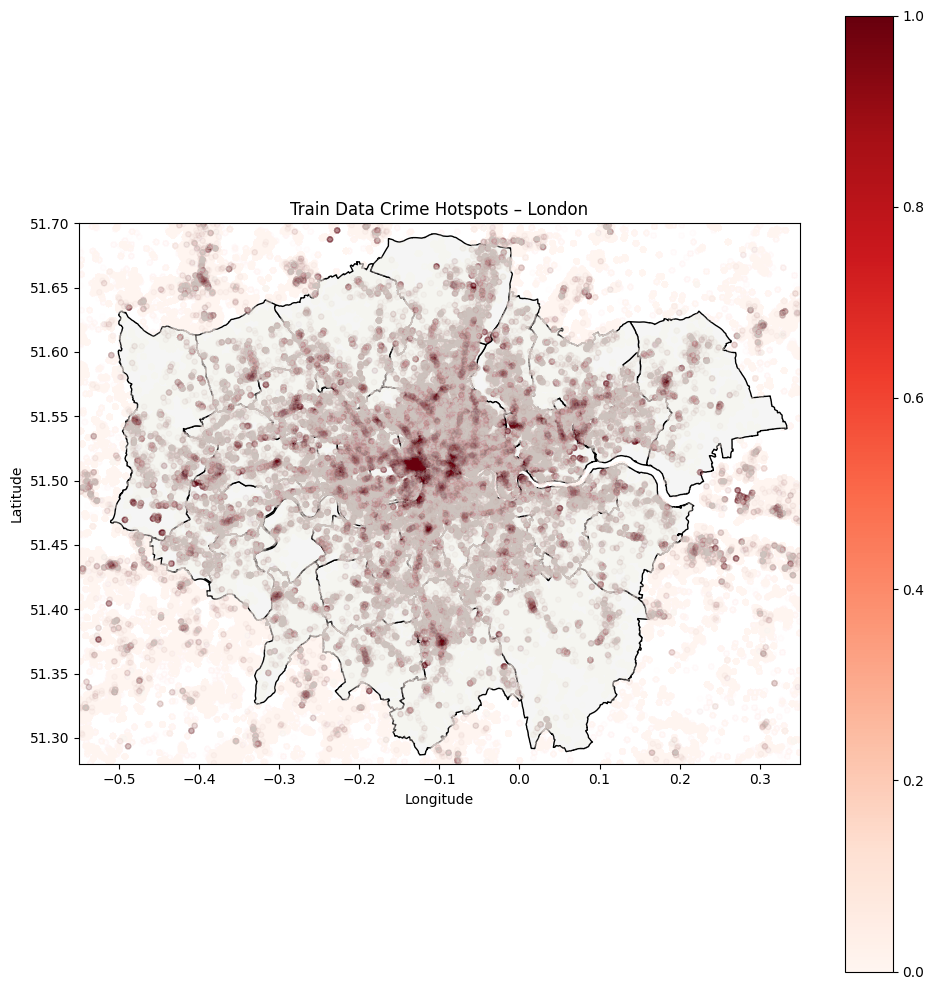

In [24]:
import geopandas as gpd
from shapely.geometry import Point

spots = (
    train_df
    .withColumn("latitude", (F.col("lat_bin") + 0.5) * grid_size)
    .withColumn("longitude", (F.col("lon_bin") + 0.5) * grid_size)
).toPandas()


# Convert predictions to GeoDataFrame
gdf_preds = gpd.GeoDataFrame(
    spots,
    geometry=gpd.points_from_xy(spots.longitude, spots.latitude),
    crs="EPSG:4326"  # WGS84
)


london_map = gpd.read_file("London_Borough_Excluding_MHW.shp").set_crs("EPSG:27700").to_crs("EPSG:4326")

fig, ax = plt.subplots(figsize=(10, 10))

# Plot base map
london_map.plot(
    ax=ax,
    color="whitesmoke",
    edgecolor="black"
)

# Plot predicted hotspots
gdf_preds.plot(
    ax=ax,
    column="hotspot",
    cmap="Reds",
    markersize=15,
    alpha=0.02,
    legend=True,
)

# Zoom to London
ax.set_xlim(LONDON_LON_MIN, LONDON_LON_MAX)
ax.set_ylim(LONDON_LAT_MIN, LONDON_LAT_MAX)

ax.set_title("Train Data Crime Hotspots – London")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()

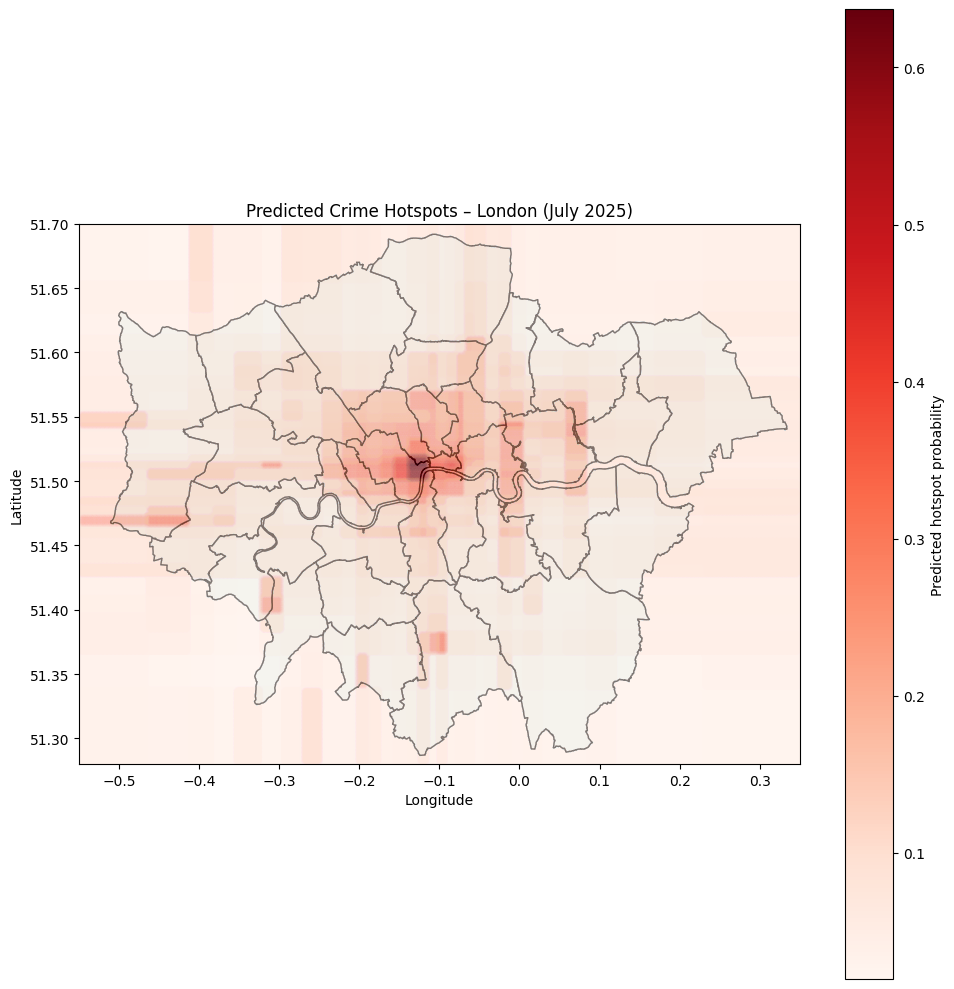

In [96]:
import geopandas as gpd
from shapely.geometry import Point

london_preds = predict_hotspots_for_area(
    spark=spark,
    model=model,
    vector_assembler=assembler,
    grid_size=grid_size,
    lat_min=LONDON_LAT_MIN,
    lat_max=LONDON_LAT_MAX,
    lon_min=LONDON_LON_MIN,
    lon_max=LONDON_LON_MAX,
    year=2025,
    month=7
)

pred_pd = london_preds.toPandas().sort_values("p_hotspot", ascending=False)


# Convert predictions to GeoDataFrame
gdf_preds = gpd.GeoDataFrame(
    pred_pd,
    geometry=gpd.points_from_xy(pred_pd.longitude, pred_pd.latitude),
    crs="EPSG:4326"  # WGS84
)


london_map = gpd.read_file("London_Borough_Excluding_MHW.shp").set_crs("EPSG:27700").to_crs("EPSG:4326")

fig, ax = plt.subplots(figsize=(10, 10))

# Plot base map
london_map.plot(
    ax=ax,
    color="whitesmoke",
    edgecolor="black"
)

# Plot predicted hotspots
gdf_preds.plot(
    ax=ax,
    column="p_hotspot",
    cmap="Reds",
    markersize=15,
    alpha=0.02,
    legend=True,
    legend_kwds={"label": "Predicted hotspot probability"}
)

# Zoom to London
ax.set_xlim(LONDON_LON_MIN, LONDON_LON_MAX)
ax.set_ylim(LONDON_LAT_MIN, LONDON_LAT_MAX)

ax.set_title("Predicted Crime Hotspots – London (July 2025)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()

We see a similar pattern as before. The model captures the general trend of crime rates and is able to aproximate the distribution, but its precision is limited.

Bigger models are able to capture more details, but they are also more complex and require more resources than we have avaliable.

## Scalabilty Testing

At last, we will analyze the scaalability of our data and system. It will be divided in three parts:

1. Speedup
2. Sizeup
3. Scaleup

For testing, we will use the same GBTClassifier model as before. In each run, a new spark context will be created. We will load the train_df we saved previously, and run the tests.

Datapoints will be divided in 4 sections:
 - Fractions: 0.25, 0.5, 0.75, 1.0
 - Cores: 1, 2, 3, 4


In [23]:
import time

def speed_up(parquet_path='train_df.parquet'):
    results = {}
    for cores in range(1, 5):
        # Create a new Spark context for each iteration with specific core count
        spark = SparkSession.builder \
            .master(f"local[{cores}]") \
            .appName(f"SpeedupTest_{cores}_cores") \
            .getOrCreate()
        
        # Load the train_df parquet
        train_df = spark.read.parquet(parquet_path)
        print("Using cores: ", cores)
        print("Number of rows: ", train_df.count())

        # Initialize GBTClassifier
        gbt = GBTClassifier(
            labelCol="hotspot",
            featuresCol="features",
            maxIter=100,
            maxDepth=6,
            seed=42
        )
        
        # Time the training process
        start_time = time.time()
        model = gbt.fit(train_df)
        end_time = time.time()
        
        training_duration = end_time - start_time
        results[cores] = training_duration
        
        # Stop the current Spark context to allow clean creation in the next iteration
        spark.stop()
        
    return results


def size_up(parquet_path='train_df.parquet'):
    results = {}
    for fraction in [0.25, 0.5, 0.75, 1.0]:
        # Create a new Spark context for each iteration with specific core count
        spark = SparkSession.builder \
            .master(f"local[*]") \
            .appName(f"SizeupTest_{fraction}_fraction") \
            .getOrCreate()
        
        # Load the train_df parquet
        train_df = spark.read.parquet(parquet_path)
        train_df = train_df.sample(fraction=fraction, seed=42)
        
        # Initialize GBTClassifier
        gbt = GBTClassifier(
            labelCol="hotspot",
            featuresCol="features",
            maxIter=100,
            maxDepth=6,
            seed=42
        )
        
        # Time the training process
        start_time = time.time()
        model = gbt.fit(train_df)
        end_time = time.time()
        
        training_duration = end_time - start_time
        results[fraction] = training_duration
        
        # Stop the current Spark context to allow clean creation in the next iteration
        spark.stop()
        
    return results


def scale_up(parquet_path='train_df.parquet'):
    results = {}
    for config in [(1, 0.25), (2, 0.5), (3, 0.75), (4, 1.0)]:
        # Create a new Spark context for each iteration with specific core count
        spark = SparkSession.builder \
            .master(f"local[{config[0]}]") \
            .appName(f"ScaleupTest_{config[0]}_cores") \
            .getOrCreate()
        
        # Load the train_df parquet
        train_df = spark.read.parquet(parquet_path)
        train_df = train_df.sample(fraction=config[1], seed=42)
        
        # Initialize GBTClassifier
        gbt = GBTClassifier(
            labelCol="hotspot",
            featuresCol="features",
            maxIter=100,
            maxDepth=6,
            seed=42
        )
        
        # Time the training process
        start_time = time.time()
        model = gbt.fit(train_df)
        end_time = time.time()
        
        training_duration = end_time - start_time
        results[config[0]] = training_duration
        
        # Stop the current Spark context to allow clean creation in the next iteration
        spark.stop()
        
    return results



Using cores:  1
Number of rows:  1032757


26/01/10 20:48:05 WARN DAGScheduler: Broadcasting large task binary with size 1002.2 KiB
26/01/10 20:48:07 WARN DAGScheduler: Broadcasting large task binary with size 1002.7 KiB
26/01/10 20:48:07 WARN DAGScheduler: Broadcasting large task binary with size 1003.7 KiB
26/01/10 20:48:08 WARN DAGScheduler: Broadcasting large task binary with size 1004.5 KiB
26/01/10 20:48:09 WARN DAGScheduler: Broadcasting large task binary with size 1006.8 KiB
26/01/10 20:48:09 WARN DAGScheduler: Broadcasting large task binary with size 1011.5 KiB
26/01/10 20:48:10 WARN DAGScheduler: Broadcasting large task binary with size 1014.6 KiB
26/01/10 20:48:11 WARN DAGScheduler: Broadcasting large task binary with size 1015.1 KiB
26/01/10 20:48:11 WARN DAGScheduler: Broadcasting large task binary with size 1016.1 KiB
26/01/10 20:48:12 WARN DAGScheduler: Broadcasting large task binary with size 1016.9 KiB
26/01/10 20:48:13 WARN DAGScheduler: Broadcasting large task binary with size 1019.2 KiB
26/01/10 20:48:13 WAR

Using cores:  2
Number of rows:  1032757


26/01/10 20:51:58 WARN DAGScheduler: Broadcasting large task binary with size 1004.0 KiB
26/01/10 20:51:58 WARN DAGScheduler: Broadcasting large task binary with size 1007.2 KiB
26/01/10 20:51:59 WARN DAGScheduler: Broadcasting large task binary with size 1007.7 KiB
26/01/10 20:51:59 WARN DAGScheduler: Broadcasting large task binary with size 1008.7 KiB
26/01/10 20:51:59 WARN DAGScheduler: Broadcasting large task binary with size 1009.5 KiB
26/01/10 20:51:59 WARN DAGScheduler: Broadcasting large task binary with size 1011.8 KiB
26/01/10 20:51:59 WARN DAGScheduler: Broadcasting large task binary with size 1016.5 KiB
26/01/10 20:51:59 WARN DAGScheduler: Broadcasting large task binary with size 1019.7 KiB
26/01/10 20:52:00 WARN DAGScheduler: Broadcasting large task binary with size 1020.2 KiB
26/01/10 20:52:00 WARN DAGScheduler: Broadcasting large task binary with size 1021.2 KiB
26/01/10 20:52:00 WARN DAGScheduler: Broadcasting large task binary with size 1021.9 KiB
26/01/10 20:52:01 WAR

Using cores:  3
Number of rows:  1032757


26/01/10 20:54:07 WARN DAGScheduler: Broadcasting large task binary with size 1001.0 KiB
26/01/10 20:54:07 WARN DAGScheduler: Broadcasting large task binary with size 1005.7 KiB
26/01/10 20:54:07 WARN DAGScheduler: Broadcasting large task binary with size 1008.8 KiB
26/01/10 20:54:08 WARN DAGScheduler: Broadcasting large task binary with size 1009.3 KiB
26/01/10 20:54:08 WARN DAGScheduler: Broadcasting large task binary with size 1010.3 KiB
26/01/10 20:54:08 WARN DAGScheduler: Broadcasting large task binary with size 1011.1 KiB
26/01/10 20:54:08 WARN DAGScheduler: Broadcasting large task binary with size 1013.4 KiB
26/01/10 20:54:08 WARN DAGScheduler: Broadcasting large task binary with size 1018.1 KiB
26/01/10 20:54:08 WARN DAGScheduler: Broadcasting large task binary with size 1021.3 KiB
26/01/10 20:54:09 WARN DAGScheduler: Broadcasting large task binary with size 1021.8 KiB
26/01/10 20:54:09 WARN DAGScheduler: Broadcasting large task binary with size 1022.8 KiB
26/01/10 20:54:09 WAR

Using cores:  4
Number of rows:  1032757


26/01/10 20:56:10 WARN DAGScheduler: Broadcasting large task binary with size 1001.3 KiB
26/01/10 20:56:10 WARN DAGScheduler: Broadcasting large task binary with size 1006.0 KiB
26/01/10 20:56:10 WARN DAGScheduler: Broadcasting large task binary with size 1009.2 KiB
26/01/10 20:56:11 WARN DAGScheduler: Broadcasting large task binary with size 1009.7 KiB
26/01/10 20:56:11 WARN DAGScheduler: Broadcasting large task binary with size 1010.7 KiB
26/01/10 20:56:11 WARN DAGScheduler: Broadcasting large task binary with size 1011.5 KiB
26/01/10 20:56:11 WARN DAGScheduler: Broadcasting large task binary with size 1013.8 KiB
26/01/10 20:56:11 WARN DAGScheduler: Broadcasting large task binary with size 1018.5 KiB
26/01/10 20:56:12 WARN DAGScheduler: Broadcasting large task binary with size 1021.7 KiB
26/01/10 20:56:12 WARN DAGScheduler: Broadcasting large task binary with size 1022.2 KiB
26/01/10 20:56:12 WARN DAGScheduler: Broadcasting large task binary with size 1023.2 KiB
26/01/10 20:56:12 WAR

Speedup Data: {1: 395.99892234802246, 2: 137.8649353981018, 3: 125.19920539855957, 4: 123.6432363986969}


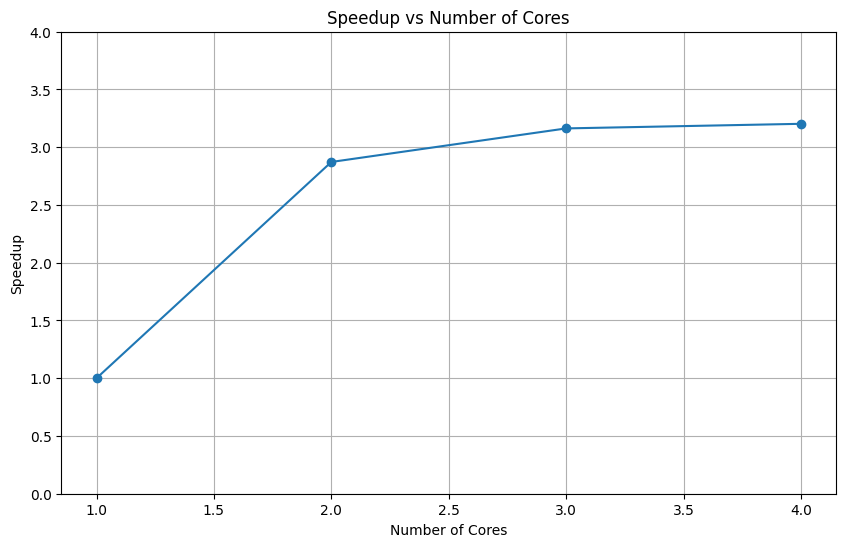

In [24]:
import json

speedup_data = speed_up()
print("Speedup Data:", speedup_data)

# Save speedup_data to a JSON file
with open('speedup_data.json', 'w') as f:
    json.dump(speedup_data, f)

speedup_x = np.array(list(speedup_data.keys()))
speedup_y = np.array(list(speedup_data.values()))
speedup_y = speedup_y[0] / speedup_y

plt.figure(figsize=(10, 6))
plt.plot(speedup_x, speedup_y, marker='o')
plt.xlabel('Number of Cores')
plt.ylabel('Speedup')
plt.title('Speedup vs Number of Cores')
plt.grid(True)
plt.ylim(0, 4)
plt.savefig('speedup_plot.png')
plt.show()

As we can see, the speedup obtained by increasing the core count is sub-linear. While 2 cores did increase the speedup, it quickly falls off by 3 cores.

26/01/10 21:01:41 WARN DAGScheduler: Broadcasting large task binary with size 1000.1 KiB
26/01/10 21:01:41 WARN DAGScheduler: Broadcasting large task binary with size 1000.6 KiB
26/01/10 21:01:42 WARN DAGScheduler: Broadcasting large task binary with size 1001.6 KiB
26/01/10 21:01:42 WARN DAGScheduler: Broadcasting large task binary with size 1002.4 KiB
26/01/10 21:01:42 WARN DAGScheduler: Broadcasting large task binary with size 1004.8 KiB
26/01/10 21:01:42 WARN DAGScheduler: Broadcasting large task binary with size 1009.5 KiB
26/01/10 21:01:42 WARN DAGScheduler: Broadcasting large task binary with size 1012.6 KiB
26/01/10 21:01:42 WARN DAGScheduler: Broadcasting large task binary with size 1013.1 KiB
26/01/10 21:01:42 WARN DAGScheduler: Broadcasting large task binary with size 1014.1 KiB
26/01/10 21:01:42 WARN DAGScheduler: Broadcasting large task binary with size 1014.9 KiB
26/01/10 21:01:42 WARN DAGScheduler: Broadcasting large task binary with size 1017.2 KiB
26/01/10 21:01:42 WAR

Sizeup Data: {0.25: 58.664562940597534, 0.5: 78.9848244190216, 0.75: 106.22125625610352, 1.0: 128.28252053260803}


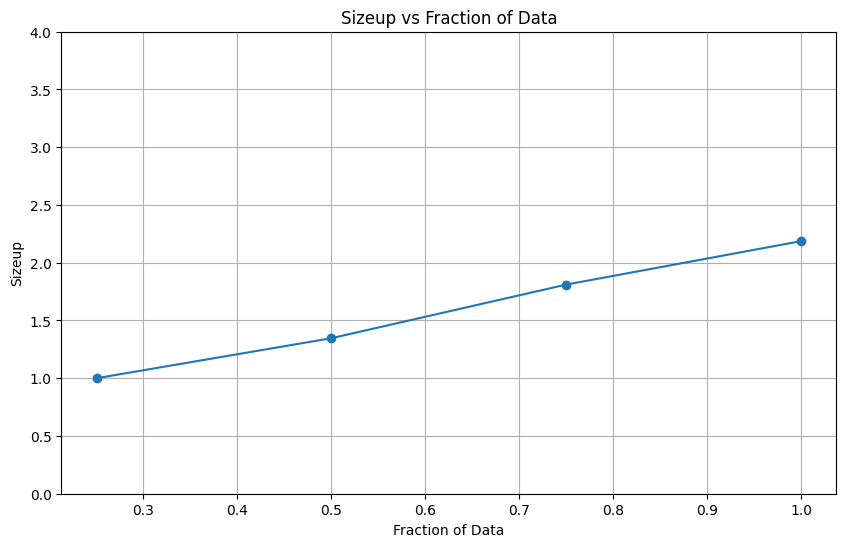

In [25]:
import json

sizeup_data = size_up()
print("Sizeup Data:", sizeup_data)

# Save sizeup_data to a JSON file
with open('sizeup_data.json', 'w') as f:
    json.dump(sizeup_data, f)

sizeup_x = np.array(list(sizeup_data.keys()))
sizeup_y = np.array(list(sizeup_data.values()))
sizeup_y = sizeup_y / sizeup_y[0]

plt.figure(figsize=(10, 6))
plt.plot(sizeup_x, sizeup_y, marker='o')
plt.xlabel('Fraction of Data')
plt.ylabel('Sizeup')
plt.title('Sizeup vs Fraction of Data')
plt.grid(True)
plt.ylim(0, 4)
plt.savefig('sizeup_plot.png')
plt.show()

Testing with fractions of data, we can see that the model is performing better than linear. From 0.25 to 1.0 (4x data increase), the model is taking only around 2.2 times the runtime to execute.

26/01/10 21:08:09 WARN DAGScheduler: Broadcasting large task binary with size 1003.0 KiB
26/01/10 21:08:09 WARN DAGScheduler: Broadcasting large task binary with size 1006.1 KiB
26/01/10 21:08:09 WARN DAGScheduler: Broadcasting large task binary with size 1006.6 KiB
26/01/10 21:08:09 WARN DAGScheduler: Broadcasting large task binary with size 1007.6 KiB
26/01/10 21:08:09 WARN DAGScheduler: Broadcasting large task binary with size 1008.4 KiB
26/01/10 21:08:09 WARN DAGScheduler: Broadcasting large task binary with size 1010.8 KiB
26/01/10 21:08:09 WARN DAGScheduler: Broadcasting large task binary with size 1015.4 KiB
26/01/10 21:08:10 WARN DAGScheduler: Broadcasting large task binary with size 1018.5 KiB
26/01/10 21:08:10 WARN DAGScheduler: Broadcasting large task binary with size 1019.0 KiB
26/01/10 21:08:10 WARN DAGScheduler: Broadcasting large task binary with size 1020.0 KiB
26/01/10 21:08:10 WARN DAGScheduler: Broadcasting large task binary with size 1020.8 KiB
26/01/10 21:08:10 WAR

Scaleup Data: {1: 73.10047841072083, 2: 84.9960207939148, 3: 102.10746383666992, 4: 122.7038209438324}


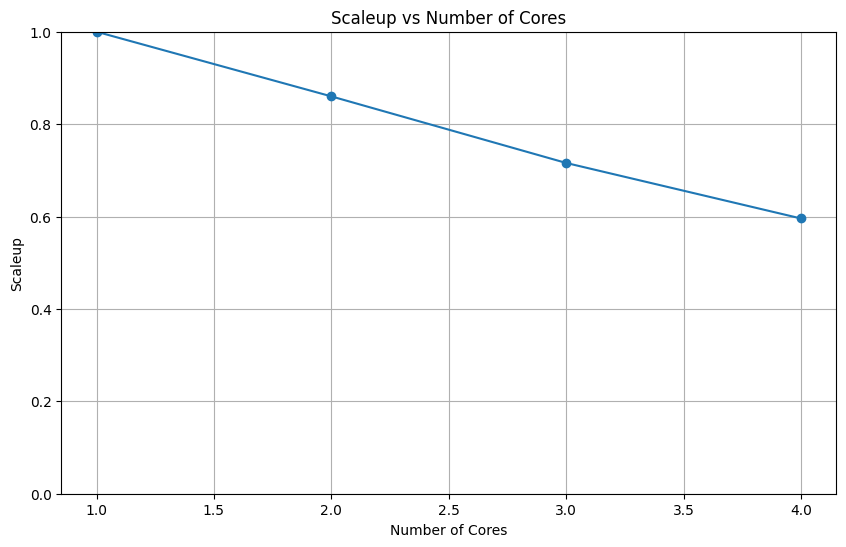

In [26]:
import json

scaleup_data = scale_up()
print("Scaleup Data:", scaleup_data)

# Save scaleup_data to a JSON file
with open('scaleup_data.json', 'w') as f:
    json.dump(scaleup_data, f)

scaleup_x = np.array(list(scaleup_data.keys()))
scaleup_y = np.array(list(scaleup_data.values()))
scaleup_y = scaleup_y[0] / scaleup_y

plt.figure(figsize=(10, 6))
plt.plot(scaleup_x, scaleup_y, marker='o')
plt.xlabel('Number of Cores')
plt.ylabel('Scaleup')
plt.title('Scaleup vs Number of Cores')
plt.grid(True)
plt.ylim(0, 1)
plt.savefig('scaleup_plot.png')
plt.show()

Finally, the model scaleup is worse than linear. As data and cores increase, the overall runtime decreases until reaching 60% of the initial runtime.